In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
dataset= pd.read_csv('datasets2/network-logs.csv')

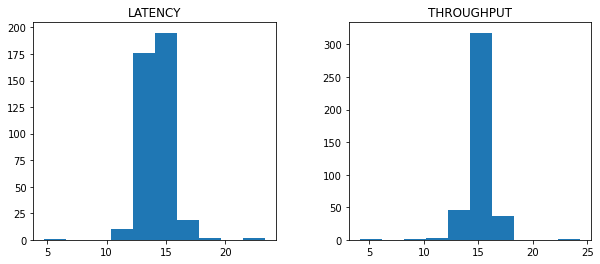

In [6]:
hist_dist = dataset[['LATENCY','THROUGHPUT']].hist(grid=False, figsize=(10,4))

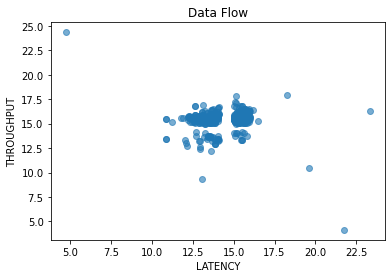

In [7]:
data = dataset[['LATENCY','THROUGHPUT']].values
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.xlabel('LATENCY')
plt.ylabel('THROUGHPUT')
plt.title('Data Flow')
plt.show()

In [9]:
"""Anomaly Detection Module"""

import math
import numpy as np


class GaussianAnomalyDetection:
    """GaussianAnomalyDetection Class"""

    def __init__(self, data):
        """GaussianAnomalyDetection constructor"""

        # Estimate Gaussian distribution.
        (self.mu_param, self.sigma_squared) = GaussianAnomalyDetection.estimate_gaussian(data)

        # Save training data.
        self.data = data

    def multivariate_gaussian(self, data):
        """Computes the probability density function of the multivariate gaussian distribution"""

        mu_param = self.mu_param
        sigma_squared = self.sigma_squared

        # Get number of training sets and features.
        (num_examples, num_features) = data.shape

        # nit probabilities matrix.
        probabilities = np.ones((num_examples, 1))

        # Go through all training examples and through all features.
        for example_index in range(num_examples):
            for feature_index in range(num_features):
                # Calculate the power of e.
                power_dividend = (data[example_index, feature_index] - mu_param[feature_index]) ** 2
                power_divider = 2 * sigma_squared[feature_index]
                e_power = -1 * power_dividend / power_divider

                # Calculate the prefix multiplier.
                probability_prefix = 1 / math.sqrt(2 * math.pi * sigma_squared[feature_index])

                # Calculate the probability for the current feature of current example.
                probability = probability_prefix * (math.e ** e_power)
                probabilities[example_index] *= probability

        # Return probabilities for all training examples.
        return probabilities

    @staticmethod
    def estimate_gaussian(data):
        """This function estimates the parameters of a Gaussian distribution using the data in X."""

        # Get number of features and number of examples.
        num_examples = data.shape[0]

        # Estimate Gaussian parameters mu and sigma_squared for every feature.
        mu_param = (1 / num_examples) * np.sum(data, axis=0)
        sigma_squared = (1 / num_examples) * np.sum((data - mu_param) ** 2, axis=0)

        # Return Gaussian parameters.
        return mu_param, sigma_squared

    @staticmethod
    def select_threshold(labels, probabilities):
        # pylint: disable=R0914
        """Finds the best threshold (epsilon) to use for selecting outliers"""

        best_epsilon = 0
        best_f1 = 0

        # History data to build the plots.
        precision_history = []
        recall_history = []
        f1_history = []

        # Calculate the epsilon steps.
        min_probability = np.min(probabilities)
        max_probability = np.max(probabilities)
        step_size = (max_probability - min_probability) / 1000

        # Go through all possible epsilons and pick the one with the highest f1 score.
        for epsilon in np.arange(min_probability, max_probability, step_size):
            predictions = probabilities < epsilon

            # The number of false positives: the ground truth label says it’s not
            # an anomaly, but our algorithm incorrectly classified it as an anomaly.
            false_positives = np.sum((predictions == 1) & (labels == 0))

            # The number of false negatives: the ground truth label says it’s an anomaly,
            # but our algorithm incorrectly classified it as not being anomalous.
            false_negatives = np.sum((predictions == 0) & (labels == 1))

            # The number of true positives: the ground truth label says it’s an
            # anomaly and our algorithm correctly classified it as an anomaly.
            true_positives = np.sum((predictions == 1) & (labels == 1))

            # Prevent division by zero.
            if (true_positives + false_positives) == 0 or (true_positives + false_negatives) == 0:
                continue

            # Precision.
            precision = true_positives / (true_positives + false_positives)

            # Recall.
            recall = true_positives / (true_positives + false_negatives)

            # F1.
            f1_score = 2 * precision * recall / (precision + recall)

            # Save history data.
            precision_history.append(precision)
            recall_history.append(recall)
            f1_history.append(f1_score)

            if f1_score > best_f1:
                best_epsilon = epsilon
                best_f1 = f1_score

        return best_epsilon, best_f1, precision_history, recall_history, f1_history

In [10]:
#Thanks to Oleksii Trekhleb: https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/anomaly_detection/gaussian_anomaly_detection.py
gaussian_anomaly_detection = GaussianAnomalyDetection(data)

print('mu param estimation: ')
print(gaussian_anomaly_detection.mu_param)

mu param estimation: 
[14.42070163 15.39209133]


In [11]:
# print sigma squared estimation
print(gaussian_anomaly_detection.sigma_squared)

[2.09674794 1.37224807]


In [12]:
targets = dataset['ANOMALY'].values.reshape((data.shape[0], 1))
probs = gaussian_anomaly_detection.multivariate_gaussian(data)
(threshold, F1, precision_, recall_, f1_) = gaussian_anomaly_detection.select_threshold(targets, probs)
print('\n')
print('threshold estimation: ')
print(threshold)



threshold estimation: 
0.00027176836728971885


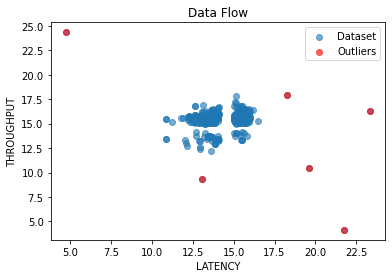

In [13]:
outliers = np.where(probs < threshold)[0]
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, label='Dataset')
plt.xlabel('LATENCY')
plt.ylabel('THROUGHPUT')
plt.title('Data Flow')
plt.scatter(data[outliers, 0], data[outliers, 1], alpha=0.6, c = 'red', label='Outliers')
plt.legend()
plt.show()

**False alarm management in anomaly detection**



In [14]:
# Sensitivity or True Positive rate (TPR) = True positive / (True Positive + False Negative)
# F1 = 2* precision * sensitivity /(Precision * sensitivy)
print('F1 score: ')
print(F1)

F1 score: 
0.6666666666666666


**Reveiver operating characteristic analysis**

In [15]:
from sklearn.metrics import roc_curve
FPR,TPR,OPC = roc_curve(targets, probs)
#TPR is true positive rate
#FPR is false positive rate
# Operating characteristic OPC

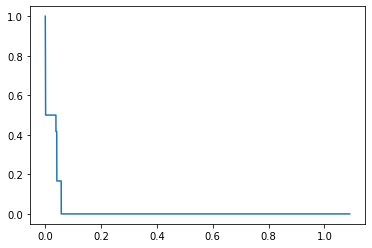

In [16]:
# Plotting sensitivity
plt.plot(OPC, TPR)

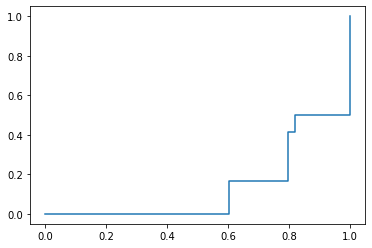

In [17]:
# Plotting ROC cuver
plt.plot(FPR, TPR)